In [1]:
import pandas as pd
import supy as sp
import matplotlib.pyplot as plt
import numpy as np


from Utilities.db_functions import (read_DB,)
db_path = r'C:\Users\xbacos\OneDrive - University of Gothenburg\Artikel_4\SUEWS Typologydatabase10.xlsx'


In [21]:

db_sh = pd.ExcelFile(db_path)
sheets = db_sh.sheet_names
db = pd.read_excel(db_path, sheet_name= sheets, index_col= 0)
# add 
for col in sheets:
    if col == 'Types':
        db[col]['descOrigin'] = db[col]['Type'].astype(str) + ', ' + db[col]['Origin'].astype(str)
    elif col == 'References': 
        db[col]['authorYear'] = db[col]['Author'].astype(str) + ', ' + db[col]['Year'].astype(str)
    elif col == 'Country':
        db[col]['descOrigin'] = db[col]['Country'].astype(str) + ', ' + db[col]['City'].astype(str)  
    elif col == 'Region':
        pass
    elif col == 'Spartacus Material':
        db[col]['descOrigin'] = db[col]['Description'].astype(str) + '; ' + db[col]['Color'].astype(str) + '; ' + db[col]['Origin'].astype(str)    
    # Calculate U-values for roof and wall new columns u_value_wall and u_value_roof
    elif col == 'Profiles':
        # Normalise traffic and energy use profiles to ensure that mean == 1
        normalisation_rows = db[col][(db[col]['Profile Type'] == 'Traffic') | (db[col]['Profile Type'] == 'Energy use')]
        cols = list(range(24))
        normalisation_rows_index = list(normalisation_rows.index)

        # # # Calculate the sum of the values for each row
        sums = db[col].loc[normalisation_rows_index, cols].sum(axis=1)

        # Avoid division by zero by replacing zero sums with NaN
        sums.replace(0, np.nan, inplace=True)

        # # Calculate the scaling factor to make the sum equal to the number of columns (24)
        scaling_factors = 24 / sums

        # Scale the values
        db[col].loc[normalisation_rows_index, cols] = db[col].loc[normalisation_rows_index, cols].multiply(scaling_factors, axis=0)

        db[col]['descOrigin'] = db[col]['Description'].astype(str) + ', ' + db[col]['Origin'].astype(str)

    elif col == 'Spartacus Surface':
        db[col]['descOrigin'] = db[col]['Description'].astype(str) + ', ' + db[col]['Origin'].astype(str)
    # Filter rows where Surface is 'Buildings'
        buildings = db['Spartacus Surface'][db['Spartacus Surface']['Surface'] == 'Buildings']

        # Calculate resistances and U-values
        for prefix in ['w', 'r']:
            materials = buildings[[f'{prefix}{i}Material' for i in range(1, 4)]].values
            thicknesses = buildings[[f'{prefix}{i}Thickness' for i in range(1, 4)]].values

            thermal_conductivities = np.vectorize(lambda x: db['Spartacus Material'].loc[x, 'Thermal Conductivity'])(materials)
            resistances = thicknesses / thermal_conductivities
            resistance_bulk = resistances.sum(axis=1)

            u_values = 1 / resistance_bulk
            db['Spartacus Surface'].loc[buildings.index, f'u_value_{prefix}all'] = u_values

        # Calculate albedo and emissivity
        for prop in ['Albedo', 'Emissivity']:
            for prefix in ['w', 'r']:
                material_col = f'{prefix}1Material'
                db['Spartacus Surface'].loc[buildings.index, f'{prop.lower()}_{prefix}all'] = db['Spartacus Material'].loc[buildings[material_col], prop].values


    else:
        db[col]['descOrigin'] = db[col]['Description'].astype(str) + ', ' + db[col]['Origin'].astype(str)

# db_sh.close() # trying this to close excelfile

In [20]:
col ='Profiles'
db[col]
normalisation_rows = db[col][(db[col]['Profile Type'] == 'Traffic') | (db[col]['Profile Type'] == 'Energy use')]
cols = list(range(24))
normalisation_rows_index = list(normalisation_rows.index)

# # # Calculate the sum of the values for each row
sums = db[col].loc[normalisation_rows_index, cols].sum(axis=1)

# Avoid division by zero by replacing zero sums with NaN
sums.replace(0, np.nan, inplace=True)

# # Calculate the scaling factor to make the sum equal to the number of columns (24)
scaling_factors = 24 / sums

# Scale the values
db[col].loc[normalisation_rows_index, cols] = db[col].loc[normalisation_rows_index, cols].multiply(scaling_factors, axis=0)

In [22]:
db_dict['Profiles'].loc[60881, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]].mean()

1.0

In [23]:
df = db_dict['Profiles'].copy()

traffic_rows = df[(df['Profile Type'] == 'Traffic') | (df['Profile Type'] == 'Energy use')]

for index, row in traffic_rows.iterrows():
    # Select columns from 0 to 23
    values = row[range(24)]
    
    # Calculate the sum of the values
    total_sum = values.sum()
    
    if total_sum != 0:
        # Calculate the scaling factor to make the sum equal to the number of columns (24)
        scaling_factor = len(values) / total_sum
        
        # Scale the values
        df.loc[index, range(24)] = values * scaling_factor




In [27]:

traffic_rows = df['Profile Type'] == 'Traffic'
cols = list(range(24))

# Calculate the sum of the values for each row
sums = df.loc[traffic_rows, cols].sum(axis=1)

# Avoid division by zero by replacing zero sums with NaN
sums.replace(0, np.nan, inplace=True)

# Calculate the scaling factor to make the sum equal to the number of columns (24)
scaling_factors = 24 / sums

# Scale the values
df.loc[traffic_rows, cols] = df.loc[traffic_rows, cols].multiply(scaling_factors, axis=0)

In [33]:
db = db_dict.copy()

# Filter rows where Surface is 'Buildings'
buildings = db['Spartacus Surface'][db['Spartacus Surface']['Surface'] == 'Buildings']

# Calculate resistances and U-values
for prefix in ['w', 'r']:
    materials = buildings[[f'{prefix}{i}Material' for i in range(1, 4)]].values
    thicknesses = buildings[[f'{prefix}{i}Thickness' for i in range(1, 4)]].values

    thermal_conductivities = np.vectorize(lambda x: db['Spartacus Material'].loc[x, 'Thermal Conductivity'])(materials)
    resistances = thicknesses / thermal_conductivities
    resistance_bulk = resistances.sum(axis=1)

    u_values = 1 / resistance_bulk
    db['Spartacus Surface'].loc[buildings.index, f'u_value_{prefix}all'] = u_values

# Calculate albedo and emissivity
for prop in ['Albedo', 'Emissivity']:
    for prefix in ['w', 'r']:
        material_col = f'{prefix}1Material'
        db['Spartacus Surface'].loc[buildings.index, f'{prop.lower()}_{prefix}all'] = db['Spartacus Material'].loc[buildings[material_col], prop].values



a = db['Spartacus Surface']

In [34]:

for row in db['Spartacus Surface'].iterrows():
    id = row[0]
    SS_surf_sel = db['Spartacus Surface'].loc[id]
    if SS_surf_sel['Surface'] == 'Buildings':
        resistance_bulk_w = 0
        resistance_bulk_r = 0

        for i in range(1,4):
            surf_w = SS_surf_sel['w'+str(i)+'Material'].item()
            thickness_w = SS_surf_sel['w'+str(i)+'Thickness'].item()
            
            surf_r = SS_surf_sel['r'+str(i)+'Material'].item()
            thickness_r = SS_surf_sel['r'+str(i)+'Thickness'].item()

            try:
                Tc_w = db['Spartacus Material'].loc[surf_w, 'Thermal Conductivity']
                resistance_w = thickness_w / Tc_w
                resistance_bulk_w = resistance_bulk_w + resistance_w
            except:
                pass

            try:
                Tc_r = db['Spartacus Material'].loc[surf_r, 'Thermal Conductivity']
                resistance_r = thickness_r / Tc_r
                resistance_bulk_r = resistance_bulk_r + resistance_r

            except:
                print(id, i)
        
        u_value_w = 1/ resistance_bulk_w
        u_value_r = 1/ resistance_bulk_r

        
        db['Spartacus Surface'].loc[id,'u_value_wall'] = u_value_w
        db['Spartacus Surface'].loc[id,'u_value_roof'] = u_value_r

        db['Spartacus Surface'].loc[id,'albedo_roof'] = db['Spartacus Material'].loc[SS_surf_sel['r1Material'], 'Albedo']
        db['Spartacus Surface'].loc[id,'albedo_wall'] = db['Spartacus Material'].loc[SS_surf_sel['w1Material'], 'Albedo']

        db['Spartacus Surface'].loc[id,'emissivity_roof'] = db['Spartacus Material'].loc[SS_surf_sel['r1Material'], 'Emissivity']
        db['Spartacus Surface'].loc[id,'emissivity_wall'] = db['Spartacus Material'].loc[SS_surf_sel['w1Material'], 'Emissivity']

b = db['Spartacus Surface']

In [2]:
# Original
db_dict= read_DB(db_path)


Veg
NonVeg
Albedo
Emissivity
OHM
Water Storage
Water
Water State
Drainage
Irrigation
Conductance
Leaf Area Index
Vegetation Growth
Leaf Growth Power
Max Vegetation Conductance
Porosity
Soil
Snow
AnthropogenicEmission
Biogen CO2
ESTM
ANOHM


In [4]:
# AnEm_dict = fill_SUEWS_AnthropogenicEmission(parameter_dict['AnthropogenicCode'], parameter_dict, db_dict) 

pda = 53661
parameter_dict = {'TrafficRate_WD': 60481, 'TrafficRate_WE': 60480, 'SnowClearingProfWD': 6013, 'SnowClearingProfWE': 6011, 'AnthropogenicCode': 53661, 'IrrigationCode': 6150, 'WaterUseProfManuWD': 600, 'WaterUseProfManuWE': 600, 'WaterUseProfAutoWD': 601, 'WaterUseProfAutoWE': 601, 'EnergyUseProfWD': 60480, 'EnergyUseProfWE': 60480, 'ActivityProfWD': 6020, 'ActivityProfWE': 6021, 'PopProfWD': 6020, 'PopProfWE': 6021, 'Paved': 20256921, 'Buildings': 20434307, 'Bare Soil': 20267467, 'Grass': 24225125, 'Evergreen Tree': 24260042, 'Deciduous Tree': 24285795, 'SoilTypeCode': 2251, 'Water': 251, 'SnowCode': 231, 'Vegetation Growth': 355, 'Biogen': 3010, 'Conductance': 442, 'TCritic_Heating_WD': 7, 'TCritic_Heating_WE': 7, 'TCritic_Cooling_WD': 7, 'TCritic_Cooling_WE': 7, 'BaseT_HC': 18.2, 'Traffic_multiplier_OSM': '{"Tertiary":16.0,"Primary":110.8, "Motorway":159.2, "Motorway Road":36.0,"Secondary":52.1,"Residential, Living street":6.6}', 'descOrigin': 'Afghanistan, LUCY'}


In [7]:
# def fill_SUEWS_AnthropogenicEmission(locator, parameter_dict, db_dict):
#     '''
#     This function is used to assign correct params to selected Snow code
#     Locator is selected code
#     This needs to be fiddled with
#     # TODO what params should be regional and not? Which ones should be removed
#     '''
locator = 53661
table = db_dict['AnthropogenicEmission']

table_dict = {
    'Code' : locator,
    'BaseT_HC' : table.loc[locator, 'BaseT_HC'],
    'QF_A_WD' : table.loc[locator, 'QF_A_WD'], 
    'QF_B_WD' : table.loc[locator, 'QF_B_WD'],
    'QF_C_WD' : table.loc[locator, 'QF_C_WD'],
    'QF_A_WE' : table.loc[locator, 'QF_A_WE'],
    'QF_B_WE' : table.loc[locator, 'QF_B_WE'],
    'QF_C_WE' : table.loc[locator, 'QF_C_WE'],
    'AHMin_WD' : table.loc[locator, 'AHMin_WD'],
    'AHMin_WE' : table.loc[locator, 'AHMin_WE'],
    'AHSlope_Heating_WD' : table.loc[locator, 'AHSlope_Heating_WD'],
    'AHSlope_Heating_WE' : table.loc[locator, 'AHSlope_Heating_WE'],
    'AHSlope_Cooling_WD' : table.loc[locator, 'AHSlope_Cooling_WD'],
    'AHSlope_Cooling_WE' : table.loc[locator, 'AHSlope_Cooling_WE'],
    'TCritic_Heating_WD' : table.loc[locator, 'TCritic_Heating_WD'],
    'TCritic_Heating_WE' : table.loc[locator, 'TCritic_Heating_WE'],
    'TCritic_Cooling_WD' : table.loc[locator, 'TCritic_Cooling_WD'],
    'TCritic_Cooling_WE' : table.loc[locator, 'TCritic_Cooling_WE'],
    'EnergyUseProfWD' : parameter_dict['EnergyUseProfWD'], #.item() ,
    'EnergyUseProfWE' : parameter_dict['EnergyUseProfWE'], #.item() ,
    'ActivityProfWD' : parameter_dict['ActivityProfWD'], #.item(),
    'ActivityProfWE' : parameter_dict['ActivityProfWE'], #.item(),
    'TraffProfWD' : parameter_dict['TrafficRate_WD'], #.item(),
    'TraffProfWE' : parameter_dict['TrafficRate_WE'], #.item(),
    'PopProfWD' : parameter_dict['PopProfWD'], #.item(),
    'PopProfWE' : parameter_dict['PopProfWE'], #.item() ,
    'MinQFMetab' : table.loc[locator, 'MinQFMetab'],
    'MaxQFMetab' : table.loc[locator, 'MaxQFMetab'],
    'MinFCMetab' : table.loc[locator, 'MinFCMetab'],
    'MaxFCMetab' : table.loc[locator, 'MaxFCMetab'],
    'FrPDDwe' : table.loc[locator, 'FrPDDwe'],
    'FrFossilFuel_Heat' : table.loc[locator, 'FrFossilFuel_Heat'],
    'FrFossilFuel_NonHeat' : table.loc[locator, 'FrFossilFuel_NonHeat'],
    'EF_umolCO2perJ' : table.loc[locator, 'EF_umolCO2perJ'],
    'EnEF_v_Jkm' : table.loc[locator, 'EnEF_v_Jkm'],
    'FcEF_v_kgkmWD' : table.loc[locator, 'FcEF_v_kgkmWD'],
    'FcEF_v_kgkmWE' : table.loc[locator, 'FcEF_v_kgkmWE'],
    'CO2PointSource' : table.loc[locator, 'CO2PointSource'],
    'TrafficUnits' : table.loc[locator, 'TrafficUnits'],
}

table_dict

# return table_dict

{'Code': 53661,
 'BaseT_HC': 18.2,
 'QF_A_WD': 0.3081357,
 'QF_B_WD': 0.0098631,
 'QF_C_WD': 0.0101826,
 'QF_A_WE': 0.3081357,
 'QF_B_WE': 0.0098631,
 'QF_C_WE': 0.0101826,
 'AHMin_WD': 15,
 'AHMin_WE': 15,
 'AHSlope_Heating_WD': 2.7,
 'AHSlope_Heating_WE': 2.7,
 'AHSlope_Cooling_WD': 2.7,
 'AHSlope_Cooling_WE': 2.7,
 'TCritic_Heating_WD': 7,
 'TCritic_Heating_WE': 7,
 'TCritic_Cooling_WD': 7,
 'TCritic_Cooling_WE': 7,
 'EnergyUseProfWD': 60480,
 'EnergyUseProfWE': 60480,
 'ActivityProfWD': 6020,
 'ActivityProfWE': 6021,
 'TraffProfWD': 60481,
 'TraffProfWE': 60480,
 'PopProfWD': 6020,
 'PopProfWE': 6021,
 'MinQFMetab': 75,
 'MaxQFMetab': 175,
 'MinFCMetab': 120,
 'MaxFCMetab': 280,
 'FrPDDwe': 1.0,
 'FrFossilFuel_Heat': 0.7,
 'FrFossilFuel_NonHeat': 0.7,
 'EF_umolCO2perJ': 1.159,
 'EnEF_v_Jkm': 3970000,
 'FcEF_v_kgkmWD': 0.2069,
 'FcEF_v_kgkmWE': 0.2069,
 'CO2PointSource': 0,
 'TrafficUnits': 1}

In [35]:
dataframes = db_dict.copy()

# Funktion för att minska antalet siffror i db-code

def remove_third_and_fourth_digits(df, suffixes):
    df = df.reset_index()  # Återställ indexet till en kolumn
    df.replace('', np.nan, inplace=True)  # Fyll tomma celler med NaN
    for col in df.columns:
        if any(col.endswith(suffix) for suffix in suffixes):
            df[col] = df[col].apply(lambda x: float(str(x)[:2] + str(x)[4:]) if pd.notnull(x) and str(x).replace('.', '', 1).isdigit() and len(str(x)) == 10 else x)
    df = df.set_index(df.columns[0])  # Sätt tillbaka den första kolumnen som index
    return df

# Lista över suffix som ska kontrolleras
suffixes_to_check = ['ID','Paved','Buildings','Bare Soil','Grass','Evergreen Tree','Deciduous Tree','Water','Biogen','Conductance',
                     'Albedo','Emissivity','Water Storage','Leaf Area Index','Water State','Leaf Growth Power','Drainage',
                     'Max Vegetation Conductance','Porosity','OHMSummerWet','OHMSummerDry','OHMWinterWet','OHMWinterDry','ANOHM','ESTM',
                     'Spartacus Surface', 'Material','Ref'

                    ]

# Iterera genom varje dataframe och minska antalet siffror i de angivna kolumnerna
for sheet_name, df in dataframes.items():
    try:
        dataframes[sheet_name] = remove_third_and_fourth_digits(df, suffixes_to_check)
        
    except:
        print(sheet_name)
        
# Funktion för att kontrollera dubbletter i index
def check_duplicate_indices(dataframes):
    duplicates = {}
    for sheet_name, df in dataframes.items():
        duplicate_indices = df.index[df.index.duplicated()].unique()
        if len(duplicate_indices) > 0:
            duplicates[sheet_name] = duplicate_indices
    return duplicates

# Kontrollera dubbletter i index för varje dataframe
duplicates = check_duplicate_indices(dataframes)

# Visa resultatet
if duplicates:
    for sheet_name, duplicate_indices in duplicates.items():
        print(f"Sheet: {sheet_name} har dubbletter i index: {duplicate_indices}")
else:
    print("Inga dubbletter hittades i index.")

save_to_db('C:/temp/newdb.xlsx', dataframes)


dataframes['Types']


Profiles
Inga dubbletter hittades i index.


,Origin,Type,Description,ProfileType,Author,Url,Buildings,Paved,Period,descOrigin
ID,,,,,,,,,,
121,Sweden,Modernism,Million programme,Residential,OB,https://upload.wikimedia.org/wikipedia/commons...,20258089.0,20256923.0,Pre80,"Modernism , Sweden"
123,Sweden,Residential Functionalism,Nordic functionalism,Residential,OB,NaN,20276682.0,20256921.0,Pre80,"Residential Functionalism, Sweden"
124,Sweden,Mixed-City Ideal,Eco-Sustainable Residential Areas,Residential,OB,https://goteborg.se/dx/api/dam/v1/collections/...,20434304.0,20256922.0,New,"Mixed-City Ideal, Sweden"
125,Sweden,Sub-urban,Wooden detached houses,Residential,OB,https://upload.wikimedia.org/wikipedia/commons...,20434306.0,20256921.0,Pst80,"Sub-urban, Sweden"
126,UK,CBD [sample run],Central London (sample data),Commercial,SG,NaN,20434307.0,20256921.0,Pre80,"CBD [sample run], UK"
127,UK,Sub-urban,Swindon (sub-urban),Residential,HW,NaN,20434307.0,20256923.0,Pre80,"Sub-urban, UK"
129,Sweden,Industrial,Gothenburg (Industrial),Industrial,FL,NaN,20256924.0,20256921.0,Pst80,"Industrial, Sweden"
122,Sweden,Traditional neighborhood,Traditional neighborhood (Stone houses),Residential,FL,NaN,20252320.0,20256921.0,Pre80,"Traditional neighborhood, Sweden"


In [ ]:
dataframes = db_dict.copy()

# Funktion för att minska antalet siffror i db-code

def remove_third_and_fourth_digits(df, suffixes):
    df = df.reset_index()  # Återställ indexet till en kolumn
    df.replace('', np.nan, inplace=True)  # Fyll tomma celler med NaN
    for col in df.columns:
        if any(col.endswith(suffix) for suffix in suffixes):
            df[col] = df[col].apply(lambda x: float(str(x)[:2] + str(x)[4:]) if pd.notnull(x) and str(x).replace('.', '', 1).isdigit() and len(str(x)) == 10 else x)
    df = df.set_index(df.columns[0])  # Sätt tillbaka den första kolumnen som index
    return df

# Lista över suffix som ska kontrolleras
suffixes_to_check = ['ID','Paved','Buildings','Bare Soil','Grass','Evergreen Tree','Deciduous Tree','Water','Biogen','Conductance',
                     'Albedo','Emissivity','Water Storage','Leaf Area Index','Water State','Leaf Growth Power','Drainage',
                     'Max Vegetation Conductance','Porosity','OHMSummerWet','OHMSummerDry','OHMWinterWet','OHMWinterDry','ANOHM','ESTM',
                     'Spartacus Surface', 'Material','Ref'

                    ]

# Iterera genom varje dataframe och minska antalet siffror i de angivna kolumnerna
for sheet_name, df in dataframes.items():
    try:
        dataframes[sheet_name] = remove_third_and_fourth_digits(df, suffixes_to_check)
        
    except:
        print(sheet_name)
        
# Funktion för att kontrollera dubbletter i index
def check_duplicate_indices(dataframes):
    duplicates = {}
    for sheet_name, df in dataframes.items():
        duplicate_indices = df.index[df.index.duplicated()].unique()
        if len(duplicate_indices) > 0:
            duplicates[sheet_name] = duplicate_indices
    return duplicates

# Kontrollera dubbletter i index för varje dataframe
duplicates = check_duplicate_indices(dataframes)

# Visa resultatet
if duplicates:
    for sheet_name, duplicate_indices in duplicates.items():
        print(f"Sheet: {sheet_name} har dubbletter i index: {duplicate_indices}")
else:
    print("Inga dubbletter hittades i index.")

save_to_db('C:/temp/newdb.xlsx', dataframes)


dataframes['Types']


In [29]:
table = db_dict['OHM']
table[(table['Surface'] == 'Grass') | (table['Surface'] == 'All vegetation')]


,General Type,Surface,Description,Origin,Season,a1,a2,a3,Ref,descOrigin
ID,,,,,,,,,,
505,Veg,All vegetation,NEW Vegetation [201] (average of codes 20 and ...,NaN,NaN,0.215,0.325,-19.85,9999.0,NEW Vegetation [201] (average of codes 20 and ...
508,Veg,All vegetation,Vegetation (average). [200] This is the averag...,NaN,NaN,0.336,0.313,-31.40,9999.0,Vegetation (average). [200] This is the averag...
509,Veg,Grass,Short grass [30],NaN,NaN,0.320,0.540,-27.40,9999.0,"Short grass [30], nan"
5010,Veg,All vegetation,Code 201 x Multiplier for winter [2012],NaN,Winter,0.270,-0.435,6.62,9999.0,"Code 201 x Multiplier for winter [2012], nan"
5011,Veg,All vegetation,Code 201 x Mulitplier for summer [2011],NaN,Summer,0.230,0.276,-16.91,9999.0,"Code 201 x Mulitplier for summer [2011], nan"


,General Type,Surface,Description,Origin,Season,a1,a2,a3,Ref,descOrigin
ID,,,,,,,,,,
505,Veg,All vegetation,NEW Vegetation [201] (average of codes 20 and ...,NaN,NaN,0.215,0.325,-19.85,9999.0,NEW Vegetation [201] (average of codes 20 and ...
508,Veg,All vegetation,Vegetation (average). [200] This is the averag...,NaN,NaN,0.336,0.313,-31.40,9999.0,Vegetation (average). [200] This is the averag...
509,Veg,Grass,Short grass [30],NaN,NaN,0.320,0.540,-27.40,9999.0,"Short grass [30], nan"
5010,Veg,All vegetation,Code 201 x Multiplier for winter [2012],NaN,Winter,0.270,-0.435,6.62,9999.0,"Code 201 x Multiplier for winter [2012], nan"
5011,Veg,All vegetation,Code 201 x Mulitplier for summer [2011],NaN,Summer,0.230,0.276,-16.91,9999.0,"Code 201 x Mulitplier for summer [2011], nan"


In [18]:
table = db_dict['OHM']


table_surf = pd.concat([table[table['Surface'] == []'Grass', 'All vegetation']] ,table[table['Surface'] =='All vegetation']])


table_surf.drop(columns =['descOrigin'])

# table_sel = table_sel.drop(columns = ['ID'])

Nc_fill_list = []
idx = 0
for desc, orig, idx in zip(table_surf['Description'].tolist() ,table_surf['Origin'].tolist(), list(range(len(table_surf['Origin'].tolist())))):
    print((str(idx) + ': ' + str(desc) + ', ' + str(orig)))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1799403170.py, line 4)

In [49]:
in_folder = r'C:\Users\xbacos\OneDrive - University of Gothenburg\Artikel_4\OUT'

# in_folder = r'C:\GitHub\SUEWS_DB_Typology_test\data\sample_data'
rc = in_folder + '/RunControl.nml'  

In [ ]:
'Albedo','Emissivity','Water Storage','Leaf Area Index','Water State','Leaf Growth Power','Drainage','Max Vegetation Conductance','Porosity','OHMSummerWet','OHMSummerDry','OHMWinterWet','OHMWinterDry','ANOHM','ESTM'


In [ ]:
'Albedo','Emissivity','Water Storage','Leaf Area Index','Water State','Leaf Growth Power','Drainage','Max Vegetation Conductance','Porosity','OHMSummerWet','OHMSummerDry','OHMWinterWet','OHMWinterDry','ANOHM','ESTM'


In [72]:
from time import sleep

code_id_dict = {
    'Region': 10,
    'Country': 11,
    'Types': 12, 

    'NonVeg': 20,
    'Soil': 22,
    'Snow': 23,
    'Veg': 24,
    'Water': 25,

    'Biogen': 30,
    'Leaf Area Index': 31,
    'Leaf Growth Power': 32,
    'Max Vegetation Conductance': 33,
    'Porosity': 34,
    'Vegetation Growth': 35,
    'Spartacus Material' : 36,
    'Spartacus Surface': 37,
    
    'Emissivity': 40,
    'Albedo': 41,   
    'Water State': 42,
    'Water Storage': 43,
    'Conductance': 44,
    'Drainage': 45,

    'OHM': 50,
    'ANOHM': 51,
    'ESTM': 52,
    'AnthropogenicEmission': 53,
    
    'Profiles': 60,
    'Irrigation': 61,
    
    'Reference': 90,
}

from datetime import datetime

def create_code(table_name):

    sleep(0.000001) # Slow down to make code unique
    table_code = str(code_id_dict[table_name]) 
    year = str(datetime.utcnow().strftime('%Y'))[2:]
    ms = str(datetime.utcnow().strftime('%S%f')) 
    code = np.int32(table_code + year + ms[4:])
    
    return code


for i in range(0,10000):
    print(create_code('NonVeg'))

20241646
20242197
20242302
20242370
20242430
20242489
20242548
20242628
20243177
20243324
20243412
20243526
20243585
20243637
20243689
20243803
20243965
20244141
20244318
20244378
20244431
20244576
20244730
20244906
20244981
20245053
20245601
20245768
20245843
20245923
20246470
20246583
20246671
20246754
20246832
20246908
20246984
20247061
20247158
20247237
20247310
20247380
20247481
20247549
20247613
20247676
20247738
20247801
20247866
20247930
20247992
20248057
20248119
20248179
20248246
20248315
20248382
20248453
20248524
20248596
20248669
20248779
20248894
20249003
20249110
20249218
20249289
20249399
20249505
20249585
20249671
20249774
20249837
20249934
20240025
20240148
20240230
20240324
20240413
20240524
20240617
20240713
20240809
20240906
20241925
20242079
20242195
20242277
20242333
20242389
20242466
20242538
20243092
20243217
20243277
20243420
20243479
20243532
20243584
20243635
20243688
20243837
20243895
20244067
20244159
20244246
20244424
20244493
20244668
20244754
20244838
2

In [66]:
str(datetime.utcnow().strftime('%Y'))[2:]

'24'

In [50]:
import pandas as pd
import supy as sp

in_folder = r'C:\Users\xbacos\OneDrive - University of Gothenburg\Artikel_4\OUT'

# in_folder = r'C:\GitHub\SUEWS_DB_Typology_test\data\sample_data'
rc = in_folder + '/RunControl.nml'  

df_state_init = sp.init_supy(rc)

2024-09-19 10:24:41,532 - SuPy - INFO - All cache cleared.


In [111]:
rc = in_folder + '/RunControl.nml'  

df_state_init = sp.init_supy(rc)

2024-09-19 09:32:21,234 - SuPy - INFO - All cache cleared.


In [5]:
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(rc, grid)
s = '2017 07'
s2 = '2012 07 10'
e = '2017 08'

# # warm week 2012  to reduce time for test setup
df_forcing=df_forcing.loc[s: e].iloc[1:]

2024-09-18 13:14:17,437 - SuPy - INFO - All cache cleared.


In [6]:
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)


2024-09-18 14:29:48,302 - SuPy - INFO - ====================
2024-09-18 14:29:48,304 - SuPy - INFO - Simulation period:
2024-09-18 14:29:48,305 - SuPy - INFO -   Start: 2017-07-01 00:05:00
2024-09-18 14:29:48,307 - SuPy - INFO -   End: 2017-08-31 23:55:00
2024-09-18 14:29:48,308 - SuPy - INFO - 
2024-09-18 14:29:48,309 - SuPy - INFO - No. of grids: 15
2024-09-18 14:29:48,310 - SuPy - INFO - SuPy is running in serial mode


In [7]:
df_output.SUEWS.loc[grid].loc[:,'QS'].plot()

<Axes: xlabel='datetime'>

Error in callback <function flush_figures at 0x000001B000964040> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [8]:
df_o = df_output.SUEWS
df_o = df_o.eval('BowenRatio=QH/QE').unstack()
df_o = df_o.eval('QS_f=QS/(QN+QF)').unstack()
df_o = df_o.eval('QH_f=QH/(QN+QF)').unstack()
df_o = df_o.eval('QE_f=QE/(QN+QF)').unstack()

KeyboardInterrupt: 

In [10]:
import pandas as pd


dict_reclass = {'ID': 60249604, 'General Type': 'Reg', 'Profile Type': 'Traffic', 'Day': 'Weekday', 'Description': 'dasfd', 'Origin': 'asdf', 'Ref': 9054, '0': '0.10000000800000002', '1': '0.10000000800000002', '2': '0.19999999200000004', '3': '0.49999999200000006', '4': '0.7999999920000002', '5': '1.000000008', '6': '1.3000000080000003', '7': '1.6999999920000002', '8': '1.5000000000000002', '9': '1.3999999920000001', '10': '1.3000000080000003', '11': '1.2000000000000002', '12': '1.2000000000000002', '13': '1.3000000080000003', '14': '1.3999999920000001', '15': '1.5000000000000002', '16': '1.6000000080000003', '17': '1.8000000000000003', '18': '1.3999999920000001', '19': '1.000000008', '20': '0.7999999920000002', '21': '0.49999999200000006', '22': '0.30000000000000004', '23': '0.10000000800000002'}


<Axes: xlabel='datetime'>

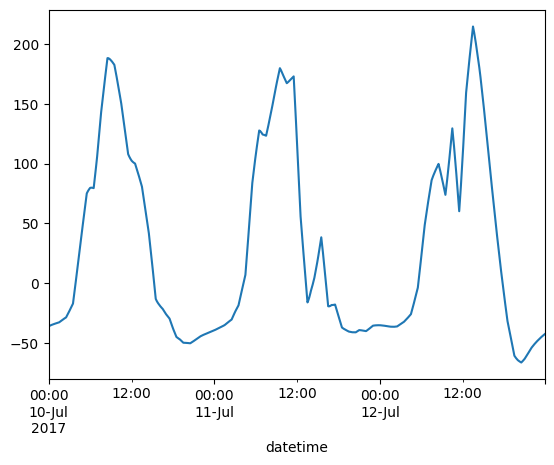

In [21]:
df_o.loc[1].loc[s:e, 'QS'].plot()

In [ ]:
path_file = r'C:\Users\xbacos\OneDrive - University of Gothenburg\Artikel_4\OUT\OSept\SUEWS_Veg.txt'

rawdata = pd.read_csv(
    path_file,
    sep=r"\s+",  # any whitespace
    comment="!",
    on_bad_lines="error",
    encoding_errors="ignore",
    skiprows=1,
    index_col=0,
)

rawdata = rawdata.dropna()
# rawdata = rawdata.apply(pd.to_numeric)
rawdata.index = rawdata.index.astype('Int64')
rawdata

In [ ]:
i = list(rawdata.index)[0]


